<a href="https://colab.research.google.com/github/jeshraghian/snntorch/blob/binary_weights/example/high_precision_conv.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **SNN with binary weights**


# Gradient-based Learning in Convolutional Spiking Neural Networks
In this tutorial, we'll use a convolutional neural network (CNN) to classify the MNIST dataset.
We will use the backpropagation through time (BPTT) algorithm to do so. This tutorial is largely the same as tutorial 2, just with a different network architecture to show how to integrate convolutions with snnTorch.

If running in Google Colab:
* Ensure you are connected to GPU by checking Runtime > Change runtime type > Hardware accelerator: GPU
* Next, install the Test PyPi distribution of snnTorch by clicking into the following cell and pressing `Shift+Enter`.

In [1]:
# Install the test PyPi Distribution of snntorch
!pip install snntorch
# !pip uninstall snntorch
# !pip install git+https://github.com/jeshraghian/snntorch.git@binary_weights#egg=snntorch

## 1. Setting up the Static MNIST Dataset
### 1.1. Import packages and setup environment

In [2]:
import snntorch as snn
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import itertools
import matplotlib.pyplot as plt

### 1.2 Define network and SNN parameters
We will use a 2conv-2MaxPool-FCN architecture for a sequence of 25 time steps.

* `alpha` is the decay rate of the synaptic current of a neuron
* `beta` is the decay rate of the membrane potential of a neuron

In [104]:
# Network Architecture
num_inputs = 28*28
num_outputs = 10
num_hidden = 1000
# Training Parameters
batch_size=128
data_path='/data/mnist'

# Temporal Dynamics
num_steps = 25
time_step = 1e-3
# tau_mem = 6.5e-4
# tau_syn = 5.5e-4
# alpha = float(np.exp(-time_step/tau_syn))
# beta = float(np.exp(-time_step/tau_mem))
alpha = 0.3
beta = 0.3

dtype = torch.float
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

### 1.3 Download MNIST Dataset
To see how to construct a validation set, refer to Tutorial 1.

In [83]:
# Define a transform
transform = transforms.Compose([
            transforms.Resize((28, 28)),
            transforms.Grayscale(),
            transforms.ToTensor(),
            transforms.Normalize((0,), (1,))])

mnist_train = datasets.MNIST(data_path, train=True, download=True, transform=transform)
mnist_test = datasets.MNIST(data_path, train=False, download=True, transform=transform)

### 1.4 Create DataLoaders

In [84]:
train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=True, drop_last=True)

## 2. Define Network
To define our network, we will import two functions from the `snntorch.neuron` module, which contains a series of neuron models and related functions.
snnTorch treats neurons as activations with recurrent connections, so that it integrates smoothly with PyTorch's pre-existing layer functions.
* `snntorch.neuron.LIF` is a simple Leaky Integrate and Fire (LIF) neuron. Specifically, it uses Stein's model which assumes instantaneous rise times for synaptic current and membrane potential.
* `snntorch.neuron.FastSigmoidSurrogate` defines separate forward and backward functions. The forward function is a Heaviside step function for spike generation. The backward function is the derivative of a fast sigmoid function, to ensure continuous differentiability.
FSS is mostly derived from:

>Neftci, E. O., Mostafa, H., and Zenke, F. (2019) Surrogate Gradient Learning in Spiking Neural Networks. https://arxiv.org/abs/1901/09948

`snn.neuron.slope` is a variable that defines the slope of the backward surrogate.
TO-DO: Include visualisation.

In [6]:
spike_grad = snn.FastSigmoidSurrogate.apply
snn.slope = 50

AttributeError: ignored

Now we can define our SNN. Defining an instance of `LIF` requires three arguments: 1) the surrogate spiking function, 2) $I_{syn}$ decay rate, $\alpha$, and 3) $V_{mem}$ decay rate, $\beta$.

The LIF neuron is simply treated as a recurrent activation. It requires initialization of the post-synaptic spikes `spk1` and `spk2`, the synaptic current `syn1` and `syn2`, and the membrane potential `mem1` and `mem2`.

We will use the final layer spikes and membrane for determining loss and accuracy, so we will record and return their histories in `spk3_rec` and `mem3_rec`.

Keep in mind, the dataset we are using is just static MNIST. I.e., it is *not* time-varying.
Therefore, we pass the same MNIST sample to the input at each time step.
This is handled in the line `cur1 = F.max_pool2d(self.conv1(x), 2)`, where `x` is the same input over the whole for-loop.

### Binarized Layer Modules
``Binarize`` converts weights to {-1, 1}.
Remove `.mul_(2).add_(1)` for {0, 1}.

In [241]:
import pdb
import math
from torch.autograd import Variable
from torch.autograd import Function

import numpy as np


def Binarize(tensor,quant_mode='det'):
    if quant_mode=='det':
        return tensor.sign()
        # tmp = tensor.clone()
        # tmp[tensor>0] = 1
        # tmp[tensor==0] = 0
        # tmp[tensor<0] = -1
        # return tmp
    else:
        return tensor.add_(1).div_(2).add_(torch.rand(tensor.size()).add(-0.5)).clamp_(0,1).round().mul_(2).add_(-1)


class HingeLoss(nn.Module):
    def __init__(self):
        super(HingeLoss,self).__init__()
        self.margin=1.0

    def hinge_loss(self,input,target):
            #import pdb; pdb.set_trace()
            output=self.margin-input.mul(target)
            output[output.le(0)]=0
            return output.mean()

    def forward(self, input, target):
        return self.hinge_loss(input,target)

class SqrtHingeLossFunction(Function):
    def __init__(self):
        super(SqrtHingeLossFunction,self).__init__()
        self.margin=1.0

    def forward(self, input, target):
        output=self.margin-input.mul(target)
        output[output.le(0)]=0
        self.save_for_backward(input, target)
        loss=output.mul(output).sum(0).sum(1).div(target.numel())
        return loss

    def backward(self,grad_output):
       input, target = self.saved_tensors
       output=self.margin-input.mul(target)
       output[output.le(0)]=0
       import pdb; pdb.set_trace()
       grad_output.resize_as_(input).copy_(target).mul_(-2).mul_(output)
       grad_output.mul_(output.ne(0).float())
       grad_output.div_(input.numel())
       return grad_output,grad_output

def Quantize(tensor,quant_mode='det',  params=None, numBits=8):
    tensor.clamp_(-2**(numBits-1),2**(numBits-1))
    if quant_mode=='det':
        tensor=tensor.mul(2**(numBits-1)).round().div(2**(numBits-1))
    else:
        tensor=tensor.mul(2**(numBits-1)).round().add(torch.rand(tensor.size()).add(-0.5)).div(2**(numBits-1))
        quant_fixed(tensor, params)
    return tensor

# import torch.nn._functions as tnnf


class BinarizeLinear(nn.Linear):

    def __init__(self, *kargs, **kwargs):
        super(BinarizeLinear, self).__init__(*kargs, **kwargs)

    def forward(self, input):

        if input.size(1) != 784:
            input.data=Binarize(input.data)
        if not hasattr(self.weight,'org'):
            self.weight.org=self.weight.data.clone()
        self.weight.data=Binarize(self.weight.org)
        out = nn.functional.linear(input, self.weight)
        if not self.bias is None:
            self.bias.org=self.bias.data.clone()
            out += self.bias.view(1, -1).expand_as(out)

        return out

class BinarizeConv2d(nn.Conv2d):

    def __init__(self, *kargs, **kwargs):
        super(BinarizeConv2d, self).__init__(*kargs, **kwargs)


    def forward(self, input):
        if input.size(1) != 3:
            input.data = Binarize(input.data)
        if not hasattr(self.weight,'org'):
            self.weight.org=self.weight.data.clone()
        self.weight.data=Binarize(self.weight.org)

        out = nn.functional.conv2d(input, self.weight, None, self.stride,
                                   self.padding, self.dilation, self.groups)

        if not self.bias is None:
            self.bias.org=self.bias.data.clone()
            out += self.bias.view(1, -1, 1, 1).expand_as(out)

        return out

Network: Low precision forward pass, high precision backprop (Additional Mod in Optimization method)

In [242]:
class LIF(nn.Module):
    """Parent class for leaky integrate and fire neuron models."""
    instances = []
    def __init__(self, alpha, beta, threshold=1.0, spike_grad=None):
        super(LIF, self).__init__()
        LIF.instances.append(self)

        self.alpha = alpha
        self.beta = beta
        self.threshold = threshold

        if spike_grad is None:
            self.spike_grad = self.Heaviside.apply
        else:
            self.spike_grad = spike_grad

    def fire(self, mem):
        """Generates spike if mem > threshold.
        Returns spk and reset."""
        mem_shift = mem - self.threshold
        spk = self.spike_grad(mem_shift).to(device)
        reset = torch.zeros_like(mem)
        spk_idx = (mem_shift > 0)
        reset[spk_idx] = torch.ones_like(mem)[spk_idx]
        return spk, reset

    def fire_single(self, mem):
        """Generates spike if mem > threshold.
        Returns spk and reset."""
        mem_shift = mem - self.threshold
        
        index = torch.argmax(mem_shift, dim=-1)
        
        spk_tmp = self.spike_grad(mem_shift)

        mask_spk1 = torch.zeros_like(spk_tmp)
        # print(mem.size())
        # print(index.size())
        mask_spk1[torch.arange(mem_shift.size()[0]), index] = 1
        spk = (spk_tmp * mask_spk1).to(device)
        # print(spk[0])
        reset = torch.zeros_like(mem)
        spk_idx = (mem_shift > 0)
        reset[spk_idx] = torch.ones_like(mem)[spk_idx]
        return spk, reset

    @classmethod
    def clear_instances(cls):
      cls.instances = []

    @staticmethod
    def init_stein(batch_size, *args):
        """Used to initialize syn, mem and spk.
        *args are the input feature dimensions.
        E.g., batch_size=128 and input feature of size=1x28x28 would require init_hidden(128, 1, 28, 28)."""
        syn = torch.zeros((batch_size, *args), device=device, dtype=dtype)
        mem = torch.zeros((batch_size, *args), device=device, dtype=dtype)
        spk = torch.zeros((batch_size, *args), device=device, dtype=dtype)

        return spk, syn, mem

    @staticmethod
    def init_srm0(batch_size, *args):
        """Used to initialize syn_pre, syn_post, mem and spk.
        *args are the input feature dimensions.
        E.g., batch_size=128 and input feature of size=1x28x28 would require init_hidden(128, 1, 28, 28)."""
        syn_pre = torch.zeros((batch_size, *args), device=device, dtype=dtype)
        syn_post = torch.zeros((batch_size, *args), device=device, dtype=dtype)
        mem = torch.zeros((batch_size, *args), device=device, dtype=dtype)
        spk = torch.zeros((batch_size, *args), device=device, dtype=dtype)

        return spk, syn_pre, syn_post, mem

    @staticmethod
    def detach(*args):
        """Used to detach input arguments from the current graph.
        Intended for use in truncated backpropagation through time where hidden state variables are global variables."""
        for state in args:
            state.detach_()

    @staticmethod
    def zeros(*args):
        """Used to clear hidden state variables to zero.
            Intended for use where hidden state variables are global variables."""
        for state in args:
            state = torch.zeros_like(state)

    @staticmethod
    class Heaviside(torch.autograd.Function):
        """Default and non-approximate spiking function for neuron.
        Forward pass: Heaviside step function.
        Backward pass: Dirac Delta clipped to 1 at x>0 instead of inf at x=1.
        This assumption holds true on the basis that a spike occurs as long as x>0 and the following time step incurs a reset."""

        @staticmethod
        def forward(ctx, input_):
            ctx.save_for_backward(input_)
            out = torch.zeros_like(input_)
            out[input_ > 0] = 1.0
            return out

        @staticmethod
        def backward(ctx, grad_output):
            input_, = ctx.saved_tensors
            grad_input = grad_output.clone()
            grad_input[input_ < 0] = 0.0
            grad = grad_input
            return grad

class Stein_single(LIF):
    """
    Stein's model of the leaky integrate and fire neuron.
    The synaptic current jumps upon spike arrival, which causes a jump in membrane potential.
    Synaptic current and membrane potential decay exponentially with rates of alpha and beta, respectively.
    For mem[T] > threshold, spk[T+1] = 0 to account for axonal delay.

    For further reading, see:
    R. B. Stein (1965) A theoretical analysis of neuron variability. Biophys. J. 5, pp. 173-194.
    R. B. Stein (1967) Some models of neuronal variability. Biophys. J. 7. pp. 37-68."""

    def __init__(self, alpha, beta, threshold=1.0, num_inputs=False, spike_grad=None, batch_size=False, hidden_init=False):
        super(Stein_single, self).__init__(alpha, beta, threshold, spike_grad)

        self.num_inputs = num_inputs
        self.batch_size = batch_size
        self.hidden_init = hidden_init

        if self.hidden_init:
            if not self.num_inputs:
                raise ValueError("num_inputs must be specified to initialize hidden states as instance variables.")
            elif not self.batch_size:
                raise ValueError("batch_size must be specified to initialize hidden states as instance variables.")
            elif hasattr(self.num_inputs, '__iter__'):
                self.spk, self.syn, self.mem = self.init_stein(self.batch_size, *(self.num_inputs)) # need to automatically call batch_size
            else:
                self.spk, self.syn, self.mem = self.init_stein(self.batch_size, self.num_inputs)

    def forward(self, input_, syn, mem):
        if not self.hidden_init:
            spk, reset = self.fire(mem)
            # input_[input_>1] = 1
            # input_[input_<-1] = -1
            syn = self.alpha * syn + input_
            mem = self.beta * mem + syn - reset

            return spk, syn, mem

        # intended for truncated-BPTT where instance variables are hidden states
        if self.hidden_init:
            self.spk, self.reset = self.fire(self.mem)
            self.syn = self.alpha * self.syn + input_
            self.mem = self.beta * self.mem + self.syn - self.reset

            return self.spk, self.syn, self.mem

    @classmethod
    def detach_hidden(cls):
        """Used to detach hidden states from the current graph.
        Intended for use in truncated backpropagation through time where hidden state variables are instance variables."""

        for layer in range(len(cls.instances)):
            cls.instances[layer].spk.detach_()
            cls.instances[layer].syn.detach_()
            cls.instances[layer].mem.detach_()

    @classmethod
    def zeros_hidden(cls):
        """Used to clear hidden state variables to zero.
        Intended for use where hidden state variables are instance variables."""

        for layer in range(len(cls.instances)):
            cls.instances[layer].spk = torch.zeros_like(cls.instances[layer].spk)
            cls.instances[layer].syn = torch.zeros_like(cls.instances[layer].syn)
            cls.instances[layer].mem = torch.zeros_like(cls.instances[layer].mem)


In [255]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()

    # initialize layers
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=12, kernel_size=5, stride=1, padding=1, bias=False)
        self.lif1 = Stein_single(alpha=alpha, beta=beta)
        self.conv2 = nn.Conv2d(in_channels=12, out_channels=64, kernel_size=5, stride=1, padding=1, bias=False)
        self.lif2 = Stein_single(alpha=alpha, beta=beta)
        self.fc2 = nn.Linear(64*5*5, 10, bias= False)
        self.lif3 = Stein_single(alpha=alpha, beta=beta)
        self.dropout = nn.Dropout(p=0.1)

    def forward(self, x):
        # Initialize LIF state variables and spike output tensors
        spk1, syn1, mem1 = self.lif1.init_stein(batch_size, 12, 13, 13)
        spk2, syn2, mem2 = self.lif1.init_stein(batch_size, 64, 5, 5)
        spk3, syn3, mem3 = self.lif2.init_stein(batch_size, 10)

        spk3_rec = []
        mem3_rec = []

        for step in range(num_steps):
            cur1 = F.max_pool2d(self.conv1(x), 2)
            spk1, syn1, mem1 = self.lif1(cur1, syn1, mem1)

            cur2 = F.max_pool2d(self.conv2(spk1), 2)
            spk2, syn2, mem2 = self.lif2(cur2, syn2, mem2)

            cur3 = self.fc2(self.dropout(spk2.view(batch_size, -1)))
            spk3, syn3, mem3 = self.lif3(cur3, syn3, mem3)

            spk3_rec.append(spk3)
            mem3_rec.append(mem3)

        return torch.stack(spk3_rec, dim=0), torch.stack(mem3_rec, dim=0)

net = Net().to(device)

Old network (if using above net, don't run the following code block)

## 3. Training
Time for training! Let's first define a couple of functions to print out test/train accuracy for each minibatch.

In [256]:
def print_batch_accuracy(data, targets, train=False):
    # output, _ = net(data.view(batch_size, -1))
    output, _ = net(data.view(batch_size, 1, 28, 28))
    _, am = output.sum(dim=0).max(1)
    acc = np.mean((targets == am). detach().cpu().numpy())
    if train is True:
        print(f"Train Set Accuracy: {acc}")
    else:
        print(f"Test Set Accuracy: {acc}")

def train_printer():
    print(f"Epoch {epoch}, Minibatch {minibatch_counter}")
    print(f"Train Set Loss: {loss_hist[counter]}")
    print(f"Test Set Loss: {test_loss_hist[counter]}")
    print_batch_accuracy(data_it, targets_it, train=True)
    print_batch_accuracy(testdata_it, testtargets_it, train=False)
    print("\n")

### 3.1 Optimizer & Loss
We'll apply the softmax function to the membrane potentials of the output layer in calculating a negative log-likelihood loss.
The Adam optimizer is used for weight updates.

Accuracy is measured by counting the spikes of the output neurons. The neuron that fires the most frequently will be our predicted class.

In [257]:
lr = 3e-3
optimizer = torch.optim.Adam(net.parameters(), lr=lr)
log_softmax_fn = nn.LogSoftmax(dim=-1)
loss_fn = nn.NLLLoss()


### 3.2 Training Loop
Now just sit back, relax, and wait for convergence.

High precision BPTT training loop

In [258]:
import math
loss_hist = []
test_loss_hist = []
counter = 0
print(f"initial_lr: {lr}")
def adjust_learning_rate(optimizer, epoch):
    """Sets the learning rate to the initial LR decayed by 10 every 30 epochs"""
    if epoch < 5: 
      new_lr = lr * (0.85 ** epoch)
      # new_lr = lr * (0.95**epoch)
    else: new_lr = lr * (0.85**4) * (0.8**(epoch-4))
    # lr = lr
    for param_group in optimizer.param_groups:
        param_group['lr'] = new_lr

# Outer training loop
for epoch in range(10):

    minibatch_counter = 0
    train_batch = iter(train_loader)

    # Minibatch training loop
    for data_it, targets_it in train_batch:
        data_it = data_it.to(device)
        targets_it = targets_it.to(device)

        # output, mem_rec = net(data_it.view(batch_size, -1))
        output, mem_rec = net(data_it.view(batch_size, 1, 28, 28)) # [28x28] or [1x28x28]?
        log_p_y = log_softmax_fn(mem_rec)
        loss_val = torch.zeros((1), dtype=dtype, device=device)

        # Sum loss over time steps to perform BPTT
        for step in range(num_steps):
          loss_val += loss_fn(log_p_y[step], targets_it)

        # adjust_learning_rate(optimizer, epoch)

        # BNN OPTimization
        optimizer.zero_grad()
        loss_val.backward()
        # for p in list(net.parameters()):
        #         if hasattr(p,'org'):
        #             p.data.copy_(p.org)
        nn.utils.clip_grad_norm_(net.parameters(), 1)
        optimizer.step()
        # for p in list(net.parameters()):
        #         if hasattr(p,'org'):
        #             p.org.copy_(p.data.clamp_(-1,1))

        # Store loss history for future plotting
        loss_hist.append(loss_val.item())

        # Test set
        test_data = itertools.cycle(test_loader)
        testdata_it, testtargets_it = next(test_data)
        testdata_it = testdata_it.to(device)
        testtargets_it = testtargets_it.to(device)

        # Test set forward pass
        # test_output, test_mem_rec = net(testdata_it.view(batch_size, -1))
        test_output, test_mem_rec = net(testdata_it.view(batch_size, 1, 28, 28))

        # Test set loss
        log_p_ytest = log_softmax_fn(test_mem_rec)
        log_p_ytest = log_p_ytest.sum(dim=0)
        loss_val_test = loss_fn(log_p_ytest, testtargets_it)
        test_loss_hist.append(loss_val_test.item())

        # Print test/train loss/accuracy
        if counter % 50 == 0:
          train_printer()
        minibatch_counter += 1
        counter += 1

    total = 0
    correct = 0
    test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=True, drop_last=False)

    with torch.no_grad():
      net.eval()
      for data in test_loader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)

        # If current batch matches batch_size, just do the usual thing
        if images.size()[0] == batch_size:
          # outputs, _ = net(images.view(batch_size, -1))
          outputs, _ = net(images.view(batch_size, 1, 28, 28))

        # If current batch does not match batch_size (e.g., is the final minibatch),
        # modify batch_size in a temp variable and restore it at the end of the else block
        else:
          temp_bs = batch_size
          batch_size = images.size()[0]
          # outputs, _ = net(images.view(images.size()[0], -1))
          outputs, _ = net(images.view(images.size()[0], 1, 28, 28))
          batch_size = temp_bs

        _, predicted = outputs.sum(dim=0).max(1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f"Total correctly classified test set images: {correct}/{total}")
    print(f"Test Set Accuracy: {100 * correct / total}%")

loss_hist_true_grad = loss_hist
test_loss_hist_true_grad = test_loss_hist

initial_lr: 0.003
Epoch 0, Minibatch 0
Train Set Loss: 57.56440734863281
Test Set Loss: 57.57048797607422
Train Set Accuracy: 0.1328125
Test Set Accuracy: 0.0859375


Epoch 0, Minibatch 50
Train Set Loss: 33.98584747314453
Test Set Loss: 34.311134338378906
Train Set Accuracy: 0.109375
Test Set Accuracy: 0.1640625


Epoch 0, Minibatch 100
Train Set Loss: 33.4441032409668
Test Set Loss: 31.04863739013672
Train Set Accuracy: 0.125
Test Set Accuracy: 0.09375


Epoch 0, Minibatch 150
Train Set Loss: 33.2514533996582
Test Set Loss: 30.19699478149414
Train Set Accuracy: 0.125
Test Set Accuracy: 0.1875


Epoch 0, Minibatch 200
Train Set Loss: 31.092679977416992
Test Set Loss: 27.07733726501465
Train Set Accuracy: 0.109375
Test Set Accuracy: 0.109375


Epoch 0, Minibatch 250
Train Set Loss: 29.47588539123535
Test Set Loss: 24.846925735473633
Train Set Accuracy: 0.1484375
Test Set Accuracy: 0.09375


Epoch 0, Minibatch 300
Train Set Loss: 29.2012882232666
Test Set Loss: 25.331663131713867
Train 

KeyboardInterrupt: ignored

In [44]:
total = 0
correct = 0
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=True, drop_last=False)

with torch.no_grad():
  net.eval()
  for data in test_loader:
    images, labels = data
    images = images.to(device)
    labels = labels.to(device)

    # If current batch matches batch_size, just do the usual thing
    if images.size()[0] == batch_size:
      # outputs, _ = net(images.view(batch_size, -1))
      outputs, _ = net(images.view(batch_size, 1, 28, 28))

    # If current batch does not match batch_size (e.g., is the final minibatch),
    # modify batch_size in a temp variable and restore it at the end of the else block
    else:
      temp_bs = batch_size
      batch_size = images.size()[0]
      # outputs, _ = net(images.view(images.size()[0], -1))
      outputs, _ = net(images.view(images.size()[0], 1, 28, 28))
      batch_size = temp_bs

    _, predicted = outputs.sum(dim=0).max(1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print(f"Total correctly classified test set images: {correct}/{total}")
print(f"Test Set Accuracy: {100 * correct / total}%")

Total correctly classified test set images: 7929/10000
Test Set Accuracy: 79.29%


In [ ]:
def adjust_learning_rate(ini_lr, lr_decay, optimizer, epoch):
    """Sets the learning rate to the initial LR decayed by 10 every 30 epochs"""
    # if epoch< 4:
    new_lr = ini_lr * (lr_decay ** epoch)
    
    # else: new_lr = lr
    for param_group in optimizer.param_groups:
        param_group['lr'] = new_lr

for lr_factor in range(5):
  lr_decay = (95 - lr_factor * 5) / 100
  net = Net().to(device)
  lr = 2e-4
  loss_hist = []
  test_loss_hist = []
  counter = 0
  print(f"initial_lr: {lr}")
  print(f"lr_decay: {lr_decay}")
  optimizer = torch.optim.Adam(net.parameters(), lr=lr, betas=(0.9, 0.999))
  log_softmax_fn = nn.LogSoftmax(dim=-1)
  loss_fn = nn.NLLLoss()
  for epoch in range(10):

      minibatch_counter = 0
      train_batch = iter(train_loader)

      # Minibatch training loop
      for data_it, targets_it in train_batch:
          data_it = data_it.to(device)
          targets_it = targets_it.to(device)

          # output, mem_rec = net(data_it.view(batch_size, -1))
          output, mem_rec = net(data_it.view(batch_size, 1, 28, 28)) # [28x28] or [1x28x28]?
          log_p_y = log_softmax_fn(mem_rec)
          loss_val = torch.zeros((1), dtype=dtype, device=device)

          # Sum loss over time steps to perform BPTT
          for step in range(num_steps):
            loss_val += loss_fn(log_p_y[step], targets_it)

          adjust_learning_rate(lr, lr_decay, optimizer, epoch)

          # BNN OPTimization
          optimizer.zero_grad()
          loss_val.backward()
          for p in list(net.parameters()):
                  if hasattr(p,'org'):
                      p.data.copy_(p.org)
          nn.utils.clip_grad_norm_(net.parameters(), 1)
          optimizer.step()
          for p in list(net.parameters()):
                  if hasattr(p,'org'):
                      p.org.copy_(p.data.clamp_(-1,1))

          # Store loss history for future plotting
          loss_hist.append(loss_val.item())

          # Test set
          test_data = itertools.cycle(test_loader)
          testdata_it, testtargets_it = next(test_data)
          testdata_it = testdata_it.to(device)
          testtargets_it = testtargets_it.to(device)

          # Test set forward pass
          # test_output, test_mem_rec = net(testdata_it.view(batch_size, -1))
          test_output, test_mem_rec = net(testdata_it.view(batch_size, 1, 28, 28))

          # Test set loss
          log_p_ytest = log_softmax_fn(test_mem_rec)
          log_p_ytest = log_p_ytest.sum(dim=0)
          loss_val_test = loss_fn(log_p_ytest, testtargets_it)
          test_loss_hist.append(loss_val_test.item())

          # Print test/train loss/accuracy
          if counter % 50 == 0:
            train_printer()
          minibatch_counter += 1
          counter += 1

  loss_hist_true_grad = loss_hist
  test_loss_hist_true_grad = test_loss_hist

  # test accuracy
  total = 0
  correct = 0
  test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=True, drop_last=False)

  with torch.no_grad():
    net.eval()
    for data in test_loader:
      images, labels = data
      images = images.to(device)
      labels = labels.to(device)

      # If current batch matches batch_size, just do the usual thing
      if images.size()[0] == batch_size:
        # outputs, _ = net(images.view(batch_size, -1))
        outputs, _ = net(images.view(batch_size, 1, 28, 28))

      # If current batch does not match batch_size (e.g., is the final minibatch),
      # modify batch_size in a temp variable and restore it at the end of the else block
      else:
        temp_bs = batch_size
        batch_size = images.size()[0]
        # outputs, _ = net(images.view(images.size()[0], -1))
        outputs, _ = net(images.view(images.size()[0], 1, 28, 28))
        batch_size = temp_bs

      _, predicted = outputs.sum(dim=0).max(1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()
  print(f"initial_lr: {lr}")
  print(f"lr_decay: {lr_decay}")
  print(f"Total correctly classified test set images: {correct}/{total}")
  print(f"Test Set Accuracy: {100 * correct / total}%")

initial_lr: 0.0002
lr_decay: 0.95
Epoch 0, Minibatch 0
Train Set Loss: 1479.259521484375
Test Set Loss: 1371.9903564453125
Train Set Accuracy: 0.109375
Test Set Accuracy: 0.0390625


Epoch 0, Minibatch 50
Train Set Loss: 331.1580810546875
Test Set Loss: 282.7850036621094
Train Set Accuracy: 0.2109375
Test Set Accuracy: 0.2890625


Epoch 0, Minibatch 100
Train Set Loss: 167.80873107910156
Test Set Loss: 134.56951904296875
Train Set Accuracy: 0.28125
Test Set Accuracy: 0.3671875


Epoch 0, Minibatch 150
Train Set Loss: 114.34632110595703
Test Set Loss: 132.60487365722656
Train Set Accuracy: 0.4140625
Test Set Accuracy: 0.4375


Epoch 0, Minibatch 200
Train Set Loss: 92.9863510131836
Test Set Loss: 66.52826690673828
Train Set Accuracy: 0.328125
Test Set Accuracy: 0.3125


Epoch 0, Minibatch 250
Train Set Loss: 72.05693054199219
Test Set Loss: 63.03389358520508
Train Set Accuracy: 0.4296875
Test Set Accuracy: 0.3671875


Epoch 0, Minibatch 300
Train Set Loss: 58.906246185302734
Test Set Lo

## 4. Results
### 4.1 Plot Training/Test Loss

In [ ]:
# Plot Loss
fig = plt.figure(facecolor="w", figsize=(10, 5))
plt.plot(loss_hist)
plt.plot(test_loss_hist)
plt.legend(["Test Loss", "Train Loss"])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

### 4.2 Test Set Accuracy

In [ ]:
def Binarize(tensor):
    tensor[tensor > 0] = 1
    tensor[tensor == 0] = 0
    tensor[tensor < 0] = -1
    return tensor

# class Net(nn.Module):
#     def __init__(self):
#         super().__init__()

#     # initialize layers
#         self.conv1 = nn.Conv2d(in_channels=1, out_channels=12, kernel_size=5, stride=1, padding=1, bias=False)
#         self.lif1 = snn.Stein(alpha=alpha, beta=beta, spike_grad=spike_grad)
#         self.conv2 = nn.Conv2d(in_channels=12, out_channels=64, kernel_size=5, stride=1, padding=1, bias=False)
#         self.lif2 = snn.Stein(alpha=alpha, beta=beta, spike_grad=spike_grad)
#         self.fc2 = nn.Linear(64*5*5, 10, bias= False)
#         self.lif3 = snn.Stein(alpha=alpha, beta=beta, spike_grad=spike_grad)

#     def forward(self, x):
#         # Initialize LIF state variables and spike output tensors
#         spk1, syn1, mem1 = self.lif1.init_stein(batch_size, 12, 13, 13)
#         spk2, syn2, mem2 = self.lif1.init_stein(batch_size, 64, 5, 5)
#         spk3, syn3, mem3 = self.lif2.init_stein(batch_size, 10)

#         spk3_rec = []
#         mem3_rec = []

#         for step in range(num_steps):
#             conv1_bin_weight = self.conv1.weight.data.clone()
#             self.conv1.weight.data = Binarize(conv1_bin_weight)
            
#             # cur1 = F.max_pool2d(self.conv1(x), 2)
#             cur1 = F.max_pool2d(F.conv2d(x, self.conv1.weight, bias=None, stride=1,
#                                    padding=1), 2)
            
#             spk1, syn1, mem1 = self.lif1(cur1, syn1, mem1)

#             conv2_bin_weight = self.conv2.weight.data.clone()
#             self.conv2.weight.data = Binarize(conv2_bin_weight)

#             # cur2 = F.max_pool2d(self.conv2(spk1), 2)
#             cur2 = F.max_pool2d(F.conv2d(spk1, self.conv2.weight, bias=None, stride=1,
#                                    padding=1), 2)
            
#             spk2, syn2, mem2 = self.lif2(cur2, syn2, mem2)

#             fc_bin_weight = self.fc2.weight.data.clone()
#             self.fc2.weight.data = Binarize(fc_bin_weight)

#             # cur3 = self.fc2(spk2.view(batch_size, -1))
#             cur3 = F.linear(spk2.view(batch_size, -1), self.fc2.weight)
#             spk3, syn3, mem3 = self.lif3(cur3, syn3, mem3)

#             spk3_rec.append(spk3)
#             mem3_rec.append(mem3)

#         return torch.stack(spk3_rec, dim=0), torch.stack(mem3_rec, dim=0)

# net = Net().to(device)

class Net(nn.Module):
    def __init__(self):
        super().__init__()

    # initialize layers
        self.fc1 = nn.Linear(num_inputs, num_hidden, bias=False)
        self.lif1 = snn.Stein(alpha=alpha, beta=beta, spike_grad=spike_grad)
        self.fc2 = nn.Linear(num_hidden, num_outputs, bias=False)
        self.lif2 = snn.Stein(alpha=alpha, beta=beta, spike_grad=spike_grad)

    def forward(self, x):
        spk1, syn1, mem1 = self.lif1.init_stein(batch_size, num_hidden)
        spk2, syn2, mem2 = self.lif2.init_stein(batch_size, num_outputs)

        spk2_rec = []
        mem2_rec = []

        for step in range(num_steps):
            fc1_bin_weight = self.fc1.weight.data.clone()
            self.fc1.weight.data = Binarize(fc1_bin_weight)
            cur1 = self.fc1(x)
            spk1, syn1, mem1 = self.lif1(cur1, syn1, mem1)

            fc2_bin_weight = self.fc2.weight.data.clone()
            self.fc2.weight.data = Binarize(fc2_bin_weight)
            cur2 = self.fc2(spk1)
            spk2, syn2, mem2 = self.lif2(cur2, syn2, mem2)
            # print(spk2.shape)

            spk2_rec.append(spk2)
            mem2_rec.append(mem2)

        return torch.stack(spk2_rec, dim=0), torch.stack(mem2_rec, dim=0)

net = Net().to(device)

Old Training Loop

In [ ]:
loss_hist = []
test_loss_hist = []
counter = 0

# Outer training loop
for epoch in range(4):

    minibatch_counter = 0
    train_batch = iter(train_loader)

    # Minibatch training loop
    for data_it, targets_it in train_batch:
        data_it = data_it.to(device)
        targets_it = targets_it.to(device)

        output, mem_rec = net(data_it.view(batch_size, -1))
        # output, mem_rec = net(data_it.view(batch_size, 1, 28, 28)) # [28x28] or [1x28x28]?
        log_p_y = log_softmax_fn(mem_rec)
        loss_val = torch.zeros((1), dtype=dtype, device=device)

        # Sum loss over time steps to perform BPTT
        for step in range(num_steps):
          loss_val += loss_fn(log_p_y[step], targets_it)

        # Gradient calculation
        optimizer.zero_grad()
        loss_val.backward(retain_graph=True)

        # Weight Update
        nn.utils.clip_grad_norm_(net.parameters(), 1)
        optimizer.step()

        # Store loss history for future plotting
        loss_hist.append(loss_val.item())

        # Test set
        test_data = itertools.cycle(test_loader)
        testdata_it, testtargets_it = next(test_data)
        testdata_it = testdata_it.to(device)
        testtargets_it = testtargets_it.to(device)

        # Test set forward pass
        test_output, test_mem_rec = net(testdata_it.view(batch_size, -1))
        # test_output, test_mem_rec = net(testdata_it.view(batch_size, 1, 28, 28))

        # Test set loss
        log_p_ytest = log_softmax_fn(test_mem_rec)
        log_p_ytest = log_p_ytest.sum(dim=0)
        loss_val_test = loss_fn(log_p_ytest, testtargets_it)
        test_loss_hist.append(loss_val_test.item())

        # Print test/train loss/accuracy
        if counter % 50 == 0:
          train_printer()
        minibatch_counter += 1
        counter += 1

loss_hist_true_grad = loss_hist
test_loss_hist_true_grad = test_loss_hist

Voila! That's it for static MNIST.

## 5. Spiking MNIST
Part of the appeal of SNNs is their ability to handle time-varying spiking data. So let's use rate-coding to convert MNIST into spiking MNIST using the `spikegen` module in Tutorial 1, and train our network with that instead.

In [17]:
from snntorch import spikegen

# MNIST to spiking-MNIST
spike_data, spike_targets = spikegen.rate(data_it, targets_it, num_outputs=num_outputs, num_steps=num_steps,
                                                      gain=1, offset=0, convert_targets=False, temporal_targets=False)

TypeError: ignored

### 5.1 Visualiser
Just so you're damn sure it's a spiking input.

In [18]:
!pip install celluloid # animating matplotlib plots made easy

In [19]:
from celluloid import Camera
from IPython.display import HTML

# Animator
spike_data_sample = spike_data[:, 0, 0].cpu()

fig, ax = plt.subplots()
camera = Camera(fig)
plt.axis('off')

for step in range(num_steps):
    im = ax.imshow(spike_data_sample[step, :, :], cmap='plasma')
    camera.snap()

# interval=40 specifies 40ms delay between frames
a = camera.animate(interval=40)
HTML(a.to_html5_video())

NameError: ignored

## 6. Define Network
The network is the same as before. The one difference is that the for-loop iterates through the first dimension of the input:
`cur1 = F.max_pool2d(self.conv1(x[step]), 2)`

### Binarized Layer Modules
``Binarize`` converts weights to {-1, 1}.
Remove `.mul_(2).add_(1)` for {0, 1}.

In [20]:
import pdb
import math
from torch.autograd import Variable
from torch.autograd import Function

import numpy as np


def Binarize(tensor,quant_mode='det'):
    if quant_mode=='det':
        return tensor.sign()
        # tmp = tensor.clone()
        # tmp[tensor>0] = 1
        # tmp[tensor==0] = 0
        # tmp[tensor<0] = -1
        # return tmp
    else:
        return tensor.add_(1).div_(2).add_(torch.rand(tensor.size()).add(-0.5)).clamp_(0,1).round().mul_(2).add_(-1)


class HingeLoss(nn.Module):
    def __init__(self):
        super(HingeLoss,self).__init__()
        self.margin=1.0

    def hinge_loss(self,input,target):
            #import pdb; pdb.set_trace()
            output=self.margin-input.mul(target)
            output[output.le(0)]=0
            return output.mean()

    def forward(self, input, target):
        return self.hinge_loss(input,target)

class SqrtHingeLossFunction(Function):
    def __init__(self):
        super(SqrtHingeLossFunction,self).__init__()
        self.margin=1.0

    def forward(self, input, target):
        output=self.margin-input.mul(target)
        output[output.le(0)]=0
        self.save_for_backward(input, target)
        loss=output.mul(output).sum(0).sum(1).div(target.numel())
        return loss

    def backward(self,grad_output):
       input, target = self.saved_tensors
       output=self.margin-input.mul(target)
       output[output.le(0)]=0
       import pdb; pdb.set_trace()
       grad_output.resize_as_(input).copy_(target).mul_(-2).mul_(output)
       grad_output.mul_(output.ne(0).float())
       grad_output.div_(input.numel())
       return grad_output,grad_output

def Quantize(tensor,quant_mode='det',  params=None, numBits=8):
    tensor.clamp_(-2**(numBits-1),2**(numBits-1))
    if quant_mode=='det':
        tensor=tensor.mul(2**(numBits-1)).round().div(2**(numBits-1))
    else:
        tensor=tensor.mul(2**(numBits-1)).round().add(torch.rand(tensor.size()).add(-0.5)).div(2**(numBits-1))
        quant_fixed(tensor, params)
    return tensor

# import torch.nn._functions as tnnf


class BinarizeLinear(nn.Linear):

    def __init__(self, *kargs, **kwargs):
        super(BinarizeLinear, self).__init__(*kargs, **kwargs)

    def forward(self, input):

        if input.size(1) != 784:
            input.data=Binarize(input.data)
        if not hasattr(self.weight,'org'):
            self.weight.org=self.weight.data.clone()
        self.weight.data=Binarize(self.weight.org)
        out = nn.functional.linear(input, self.weight)
        if not self.bias is None:
            self.bias.org=self.bias.data.clone()
            out += self.bias.view(1, -1).expand_as(out)

        return out

class BinarizeConv2d(nn.Conv2d):

    def __init__(self, *kargs, **kwargs):
        super(BinarizeConv2d, self).__init__(*kargs, **kwargs)


    def forward(self, input):
        if input.size(1) != 3:
            input.data = Binarize(input.data)
        if not hasattr(self.weight,'org'):
            self.weight.org=self.weight.data.clone()
        self.weight.data=Binarize(self.weight.org)

        out = nn.functional.conv2d(input, self.weight, None, self.stride,
                                   self.padding, self.dilation, self.groups)

        if not self.bias is None:
            self.bias.org=self.bias.data.clone()
            out += self.bias.view(1, -1, 1, 1).expand_as(out)

        return out

In [161]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()

    # initialize layers
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=12, kernel_size=5, stride=1, padding=1, bias=False)
        self.lif1 = Stein_single(alpha=alpha, beta=beta)
        self.conv2 = nn.Conv2d(in_channels=12, out_channels=64, kernel_size=5, stride=1, padding=1, bias=False)
        self.lif2 = Stein_single(alpha=alpha, beta=beta)
        self.fc2 = nn.Linear(64*5*5, 10, bias= False)
        self.lif3 = Stein_single(alpha=alpha, beta=beta)
        self.dropout = nn.Dropout(p=0.2)
    def forward(self, x):
        # Initialize LIF state variables and spike output tensors
        spk1, syn1, mem1 = self.lif1.init_stein(batch_size, 12, 13, 13)
        spk2, syn2, mem2 = self.lif1.init_stein(batch_size, 64, 5, 5)
        spk3, syn3, mem3 = self.lif2.init_stein(batch_size, 10)

        spk3_rec = []
        mem3_rec = []

        for step in range(num_steps):
            cur1 = F.max_pool2d(self.conv1(x[step]), 2)
            spk1, syn1, mem1 = self.lif1(cur1, syn1, mem1)

            cur2 = F.max_pool2d(self.conv2(spk1), 2)
            spk2, syn2, mem2 = self.lif2(cur2, syn2, mem2)

            cur3 = self.fc2(self.dropout(spk2.view(batch_size, -1)))
            spk3, syn3, mem3 = self.lif3(cur3, syn3, mem3)

            spk3_rec.append(spk3)
            mem3_rec.append(mem3)

        return torch.stack(spk3_rec, dim=0), torch.stack(mem3_rec, dim=0)

net = Net().to(device)

## 7. Training
We make a slight modification to our print-out functions to handle the new first dimension of the input:

In [162]:
def print_batch_accuracy(data, targets, train=False):
    # output, _ = net(data.view(num_steps, batch_size, -1))
    output, _ = net(data.view(num_steps, batch_size, 1, 28, 28))
    _, idx = output.sum(dim=0).max(1)
    acc = np.mean((targets == idx).detach().cpu().numpy())

    if train:
        print(f"Train Set Accuracy: {acc}")
    else:
        print(f"Test Set Accuracy: {acc}")

def train_printer():
    print(f"Epoch {epoch}, Minibatch {minibatch_counter}")
    print(f"Train Set Loss: {loss_hist[counter]}")
    print(f"Test Set Loss: {test_loss_hist[counter]}")
    print_batch_accuracy(spike_data, spike_targets, train=True)
    print_batch_accuracy(test_spike_data, test_spike_targets, train=False)
    print("\n")


### 7.1 Optimizer & Loss
We'll keep our optimizer and loss the exact same as the static MNIST case.

In [163]:
lr = 1e-3
optimizer = torch.optim.Adam(net.parameters(), lr=lr)
log_softmax_fn = nn.LogSoftmax(dim=-1)
loss_fn = nn.NLLLoss()

### 7.2 Training Loop

High precision BPTT training loop

In [159]:
loss_hist = []
test_loss_hist = []
counter = 0
def adjust_learning_rate(optimizer, epoch):
    """Sets the learning rate to the initial LR decayed by 10 every 30 epochs"""
    if epoch < 5: 
      new_lr = lr * (0.85 ** epoch)
      # new_lr = lr * (0.95**epoch)
    else: new_lr = lr * (0.85**4) * (0.8**(epoch-4))
    # lr = lr
    for param_group in optimizer.param_groups:
        param_group['lr'] = new_lr

# Outer training loop
for epoch in range(10):

    minibatch_counter = 0
    train_batch = iter(train_loader)

    # Minibatch training loop
    for data_it, targets_it in train_batch:
        data_it = data_it.to(device)
        targets_it = targets_it.to(device)

        # Spike generator
        spike_data, spike_targets = spikegen.rate(data_it, targets_it, num_outputs=num_outputs, num_steps=num_steps,
                                                  gain=1, offset=0)
        

        # Forward pass
        # output, mem_rec = net(spike_data.view(num_steps, batch_size, -1))
        output, mem_rec = net(spike_data.view(num_steps, batch_size, 1, 28, 28))
        log_p_y = log_softmax_fn(mem_rec)
        loss_val = torch.zeros(1, dtype=dtype, device=device)

        # Sum loss over time steps to perform BPTT
        for step in range(num_steps):
          loss_val += loss_fn(log_p_y[step], targets_it)
        
        adjust_learning_rate(optimizer, epoch)

        # BNN OPTimization
        optimizer.zero_grad()
        loss_val.backward()
        # for p in list(net.parameters()):
        #         if hasattr(p,'org'):
        #             p.data.copy_(p.org)
        nn.utils.clip_grad_norm_(net.parameters(), 1)
        optimizer.step()
        # for p in list(net.parameters()):
        #         if hasattr(p,'org'):
        #             p.org.copy_(p.data.clamp_(-1,1))

        # Store loss history for future plotting
        loss_hist.append(loss_val.item())

        # Test set
        test_data = itertools.cycle(test_loader)
        testdata_it, testtargets_it = next(test_data)
        testdata_it = testdata_it.to(device)
        testtargets_it = testtargets_it.to(device)

        # Test set spike conversion
        test_spike_data, test_spike_targets = spikegen.rate(testdata_it, testtargets_it, num_outputs=num_outputs,
                                                            num_steps=num_steps, gain=1, offset=0)

        # Test set forward pass
        # test_output, test_mem_rec = net(test_spike_data.view(num_steps, batch_size, -1))
        test_output, test_mem_rec = net(test_spike_data.view(num_steps, batch_size, 1, 28, 28))

        # Test set loss
        log_p_ytest = log_softmax_fn(test_mem_rec)
        log_p_ytest = log_p_ytest.sum(dim=0)
        loss_val_test = loss_fn(log_p_ytest, testtargets_it)
        test_loss_hist.append(loss_val_test.item())

        # Print test/train loss/accuracy
        if counter % 50 == 0:
          train_printer()
        minibatch_counter += 1
        counter += 1

loss_hist_true_grad = loss_hist
test_loss_hist_true_grad = test_loss_hist

Epoch 0, Minibatch 0
Train Set Loss: 57.558692932128906
Test Set Loss: 57.49127197265625
Train Set Accuracy: 0.1640625
Test Set Accuracy: 0.109375


Epoch 0, Minibatch 50
Train Set Loss: 34.72120666503906
Test Set Loss: 32.96978759765625
Train Set Accuracy: 0.1875
Test Set Accuracy: 0.1796875


Epoch 0, Minibatch 100
Train Set Loss: 34.23112487792969
Test Set Loss: 36.1490592956543
Train Set Accuracy: 0.1875
Test Set Accuracy: 0.109375


Epoch 0, Minibatch 150
Train Set Loss: 37.42290496826172
Test Set Loss: 29.965831756591797
Train Set Accuracy: 0.0546875
Test Set Accuracy: 0.1171875


Epoch 0, Minibatch 200
Train Set Loss: 34.34812927246094
Test Set Loss: 33.90836715698242
Train Set Accuracy: 0.109375
Test Set Accuracy: 0.1796875


Epoch 0, Minibatch 250
Train Set Loss: 32.98904037475586
Test Set Loss: 30.501550674438477
Train Set Accuracy: 0.1875
Test Set Accuracy: 0.1328125


Epoch 0, Minibatch 300
Train Set Loss: 33.53864669799805
Test Set Loss: 31.875106811523438
Train Set Accura

## 8. Spiking MNIST Results
### 8.1 Plot Training/Test Loss

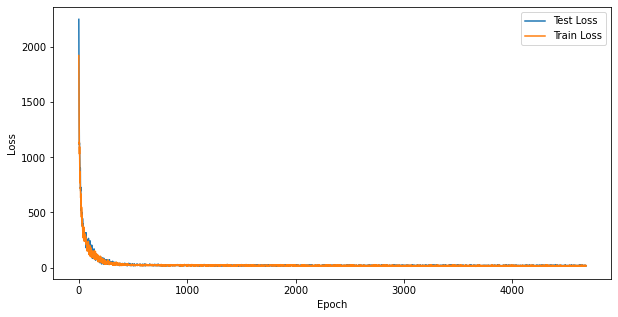

In [25]:
# Plot Loss
fig = plt.figure(facecolor="w", figsize=(10, 5))
plt.plot(loss_hist)
plt.plot(test_loss_hist)
plt.legend(["Test Loss", "Train Loss"])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

### 8.2 Test Set Accuracy

In [160]:
total = 0
correct = 0
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=True, drop_last=False)

with torch.no_grad():
  net.eval()
  for data in test_loader:
    images, labels = data
    images = images.to(device)
    labels = labels.to(device)

    # If current batch matches batch_size, just do the usual thing
    if images.size()[0] == batch_size:
      spike_test, spike_targets = spikegen.rate(images, labels, num_outputs=num_outputs, num_steps=num_steps,
                                                            gain=1, offset=0)

      # outputs, _ = net(spike_test.view(num_steps, batch_size, -1))
      outputs, _ = net(spike_test.view(num_steps, batch_size, 1, 28, 28))

    # If current batch does not match batch_size (e.g., is the final minibatch),
    # modify batch_size in a temp variable and restore it at the end of the else block
    else:
      temp_bs = batch_size
      batch_size = images.size()[0]
      spike_test, spike_targets = spikegen.rate(images, labels, num_outputs=num_outputs, num_steps=num_steps,
                                                            gain=1, offset=0)
      # outputs, _ = net(spike_test.view(num_steps, images.size()[0], -1))
      outputs, _ = net(spike_test.view(num_steps, images.size()[0], 1, 28, 28))
      batch_size = temp_bs

    _, predicted = outputs.sum(dim=0).max(1)
    total += spike_targets.size(0)
    correct += (predicted == spike_targets).sum().item()

print(f"Total correctly classified test set images: {correct}/{total}")
print(f"Test Set Accuracy: {100 * correct / total}%")

Total correctly classified test set images: 8746/10000
Test Set Accuracy: 87.46%


In [ ]:
loss_hist = []
test_loss_hist = []
counter = 0

# Outer training loop
for epoch in range(1):
    minibatch_counter = 0
    data = iter(train_loader)

    # Minibatch training loop
    for data_it, targets_it in data:
        data_it = data_it.to(device)
        targets_it = targets_it.to(device)

        # Spike generator
        spike_data, spike_targets = spikegen.rate(data_it, targets_it, num_outputs=num_outputs, num_steps=num_steps,
                                                  gain=1, offset=0, convert_targets=False, temporal_targets=False)

        # Forward pass
        output, mem_rec = net(spike_data.view(num_steps, batch_size, -1))
        # output, mem_rec = net(spike_data.view(num_steps, batch_size, 1, 28, 28))
        log_p_y = log_softmax_fn(mem_rec)
        loss_val = torch.zeros(1, dtype=dtype, device=device)

        # Sum loss over time steps to perform BPTT
        for step in range(num_steps):
          loss_val += loss_fn(log_p_y[step], targets_it)

        # Gradient Calculation
        optimizer.zero_grad()
        loss_val.backward(retain_graph=True)
        nn.utils.clip_grad_norm_(net.parameters(), 1)

        # Weight Update
        optimizer.step()

        # Store Loss history
        loss_hist.append(loss_val.item())

        # Test set
        test_data = itertools.cycle(test_loader)
        testdata_it, testtargets_it = next(test_data)
        testdata_it = testdata_it.to(device)
        testtargets_it = testtargets_it.to(device)

        # Test set spike conversion
        test_spike_data, test_spike_targets = spikegen.rate(testdata_it, testtargets_it, num_outputs=num_outputs,
                                                            num_steps=num_steps, gain=1, offset=0, convert_targets=False,
                                                            temporal_targets=False)

        # Test set forward pass
        test_output, test_mem_rec = net(test_spike_data.view(num_steps, batch_size, -1))
        # test_output, test_mem_rec = net(test_spike_data.view(num_steps, batch_size, 1, 28, 28))

        # Test set loss
        log_p_ytest = log_softmax_fn(test_mem_rec)
        log_p_ytest = log_p_ytest.sum(dim=0)
        loss_val_test = loss_fn(log_p_ytest, test_spike_targets)
        test_loss_hist.append(loss_val_test.item())

        # Print test/train loss/accuracy
        if counter % 50 == 0:
            train_printer()
        minibatch_counter += 1
        counter += 1

loss_hist_true_grad = loss_hist
test_loss_hist_true_grad = test_loss_hist

In [ ]:
# spike_fn = FSS.apply
# snn.neuron.slope = 50
spike_grad = snn.FastSigmoidSurrogate.apply
snn.slope = 50

def Binarize(tensor):
    tensor[tensor > 0] = 1
    tensor[tensor<=0] = 0
    return tensor
# class Net(nn.Module):
#     def __init__(self):
#         super().__init__()

#     # initialize layers
#         self.conv1 = nn.Conv2d(in_channels=1, out_channels=12, kernel_size=5, stride=1, padding=1, bias=False)
#         self.lif1 = snn.Stein(alpha=alpha, beta=beta, spike_grad=spike_grad)
#         self.conv2 = nn.Conv2d(in_channels=12, out_channels=64, kernel_size=5, stride=1, padding=1, bias=False)
#         self.lif2 = snn.Stein(alpha=alpha, beta=beta, spike_grad=spike_grad)
#         self.fc2 = nn.Linear(64*5*5, 10, bias= False)
#         self.lif3 = snn.Stein(alpha=alpha, beta=beta, spike_grad=spike_grad)

#     def forward(self, x):
#         # Initialize LIF state variables and spike output tensors
#         spk1, syn1, mem1 = self.lif1.init_stein(batch_size, 12, 13, 13)
#         spk2, syn2, mem2 = self.lif1.init_stein(batch_size, 64, 5, 5)
#         spk3, syn3, mem3 = self.lif2.init_stein(batch_size, 10)

#         spk3_rec = []
#         mem3_rec = []

#         for step in range(num_steps):
#             conv1_bin_weight = self.conv1.weight.data.clone()
#             self.conv1.weight.data = Binarize(conv1_bin_weight)
            
#             cur1 = F.max_pool2d(self.conv1(x[step]), 2)
#             # cur1 = F.max_pool2d(F.conv2d(x, self.conv1.weight, bias=None, stride=1,
#             #                        padding=1), 2)
            
#             spk1, syn1, mem1 = self.lif1(cur1, syn1, mem1)

#             conv2_bin_weight = self.conv2.weight.data.clone()
#             self.conv2.weight.data = Binarize(conv2_bin_weight)

#             cur2 = F.max_pool2d(self.conv2(spk1), 2)
#             # cur2 = F.max_pool2d(F.conv2d(spk1, self.conv2.weight, bias=None, stride=1,
#             #                        padding=1), 2)
            
#             spk2, syn2, mem2 = self.lif2(cur2, syn2, mem2)

#             fc_bin_weight = self.fc2.weight.data.clone()
#             self.fc2.weight.data = Binarize(fc_bin_weight)

#             cur3 = self.fc2(spk2.view(batch_size, -1))
#             # cur3 = F.linear(spk2.view(batch_size, -1), self.fc2.weight)
#             spk3, syn3, mem3 = self.lif3(cur3, syn3, mem3)

#             spk3_rec.append(spk3)
#             mem3_rec.append(mem3)

#         return torch.stack(spk3_rec, dim=0), torch.stack(mem3_rec, dim=0)

# net = Net().to(device)

class Net(nn.Module):
    def __init__(self):
        super().__init__()

    # initialize layers
        self.fc1 = nn.Linear(num_inputs, num_hidden, bias=False)
        self.lif1 = snn.Stein(alpha=alpha, beta=beta, spike_grad=spike_grad)
        self.fc2 = nn.Linear(num_hidden, num_outputs, bias=False)
        self.lif2 = snn.Stein(alpha=alpha, beta=beta, spike_grad=spike_grad)

    def forward(self, x):
        spk1, syn1, mem1 = self.lif1.init_stein(batch_size, num_hidden)
        spk2, syn2, mem2 = self.lif2.init_stein(batch_size, num_outputs)

        spk2_rec = []
        mem2_rec = []

        for step in range(num_steps):
            fc1_bin_weight = self.fc1.weight.data.clone()
            self.fc1.weight.data = Binarize(fc1_bin_weight)
            cur1 = self.fc1(x[step])
            spk1, syn1, mem1 = self.lif1(cur1, syn1, mem1)

            fc2_bin_weight = self.fc2.weight.data.clone()
            self.fc2.weight.data = Binarize(fc2_bin_weight)
            cur2 = self.fc2(spk1)
            spk2, syn2, mem2 = self.lif2(cur2, syn2, mem2)
            # print(spk2.shape)

            spk2_rec.append(spk2)
            mem2_rec.append(mem2)

        return torch.stack(spk2_rec, dim=0), torch.stack(mem2_rec, dim=0)

net = Net().to(device)
# class Net(nn.Module):
#     def __init__(self):
#         super().__init__()

#         # initialize layers
#         self.conv1 = nn.Conv2d(in_channels=1, out_channels=12, kernel_size=5, stride=1, padding=1)
#         self.lif1 = snn.Stein(alpha=alpha, beta=beta, spike_grad=spike_grad)
#         self.conv2 = nn.Conv2d(in_channels=12, out_channels=64, kernel_size=5, stride=1, padding=1)
#         self.lif2 = snn.Stein(alpha=alpha, beta=beta, spike_grad=spike_grad)
#         self.fc2 = nn.Linear(64*5*5, 10)
#         self.lif3 = snn.Stein(alpha=alpha, beta=beta, spike_grad=spike_grad)

#         # self.conv1 = nn.Conv2d(in_channels=1, out_channels=3, kernel_size=3, stride=1, padding=0)
#         # self.lif1 = LIF(spike_fn=spike_fn, alpha=alpha, beta=beta)
#         # self.fc1 = nn.Linear(26*26*3, 10)
#         # self.lif2 = LIF(spike_fn=spike_fn, alpha=alpha, beta=beta)

#     def forward(self, x):
#         # Initialize LIF state variables and spike output tensors
#         spk1, syn1, mem1 = self.lif1.init_stein(batch_size, 12, 13, 13)
#         spk2, syn2, mem2 = self.lif2.init_stein(batch_size, 64, 5, 5)
#         spk3, syn3, mem3 = self.lif3.init_stein(batch_size, 10)

#         spk3_rec = []
#         mem3_rec = []

#         for step in range(num_steps):
#             cur1 = F.max_pool2d(self.conv1(x[step]), 2) # add max-pooling to membrane or spikes?
#             spk1, syn1, mem1 = self.lif1(cur1, syn1, mem1)
#             cur2 = F.max_pool2d(self.conv2(spk1), 2)
#             spk2, syn2, mem2 = self.lif2(cur2, syn2, mem2)
#             cur3 = self.fc2(spk2.view(batch_size, -1))
#             spk3, syn3, mem3 = self.lif3(cur3, syn3, mem3)

#             spk3_rec.append(spk3)
#             mem3_rec.append(mem3)

#         return torch.stack(spk3_rec, dim=0), torch.stack(mem3_rec, dim=0)

# net = Net().to(device)

Professor Lu has kidnapped my daughter and won't return her until I hit 99.99% accuracy, please help
-JE